**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Preprocessing**

In [4]:
from os import listdir

weather_df = pd.read_csv('datasets/weather_hourly_helsinki.csv')

weather_headers = weather_df.loc[0:2, :]

weather_df = weather_df.loc[1:, :]
weather_df.columns = weather_df.iloc[0]
weather_df = weather_df.loc[2:, :]

bike_df = pd.DataFrame(columns=['Departure', 'Return', 'Departure station id', 'Departure station name',
                       'Return station id', 'Return station name', 'Covered distance (m)', 'Duration (sec.)'])

for dataset in listdir('datasets'):
  if dataset == 'weather_hourly_helsinki.csv' or dataset.endswith('.gz') or dataset.startswith('agg'):
    continue

  temp_df = pd.read_csv('datasets/' + dataset, low_memory=False)
  bike_df = pd.concat([bike_df, temp_df])

bike_df['Departure'] = pd.to_datetime(bike_df['Departure'], format='mixed')
bike_df['Return'] = pd.to_datetime(bike_df['Return'], format='mixed')

/tmp/ipykernel_2401280/553074746.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bike_df = pd.concat([bike_df, temp_df])


**Aggregating Data**

In [2]:
aggregated = pd.DataFrame(columns=[
    'Departure station id',
    'Return station id',
    'Departure station name',
    'Return station name',
    'Trip count'
])

for year in range(2016, 2024):
  bike_df_year = bike_df[bike_df['Departure'].dt.year == year]
  aggregated_year = bike_df_year.groupby([
      'Departure station id',
      'Return station id',
      'Departure station name',
      'Return station name',
      pd.Grouper(key='Departure', freq='H'),
  ]).size().reset_index(name='Trip count')
  aggregated = pd.concat([aggregated, aggregated_year])
  aggregated_year.to_csv(f'datasets/aggregated_{year}.csv', index=False)

aggregated.to_csv('datasets/aggregated.csv', index=False)
print(aggregated)


/tmp/ipykernel_130389/2610724372.py:22: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  aggregated = pd.read_csv('datasets/aggregated.csv')


         Departure station id Return station id Departure station name  \
0                         997               997      Workshop Helsinki   
1                         997               997      Workshop Helsinki   
2                         997               997      Workshop Helsinki   
3                         997               997      Workshop Helsinki   
4                         997               997      Workshop Helsinki   
...                       ...               ...                    ...   
16770585                  997               997      Workshop Helsinki   
16770586                  997               997      Workshop Helsinki   
16770587                  997               997      Workshop Helsinki   
16770588                  997               997      Workshop Helsinki   
16770589                  997               997      Workshop Helsinki   

         Return station name  Trip count            Departure  
0          Workshop Helsinki           6  2016-

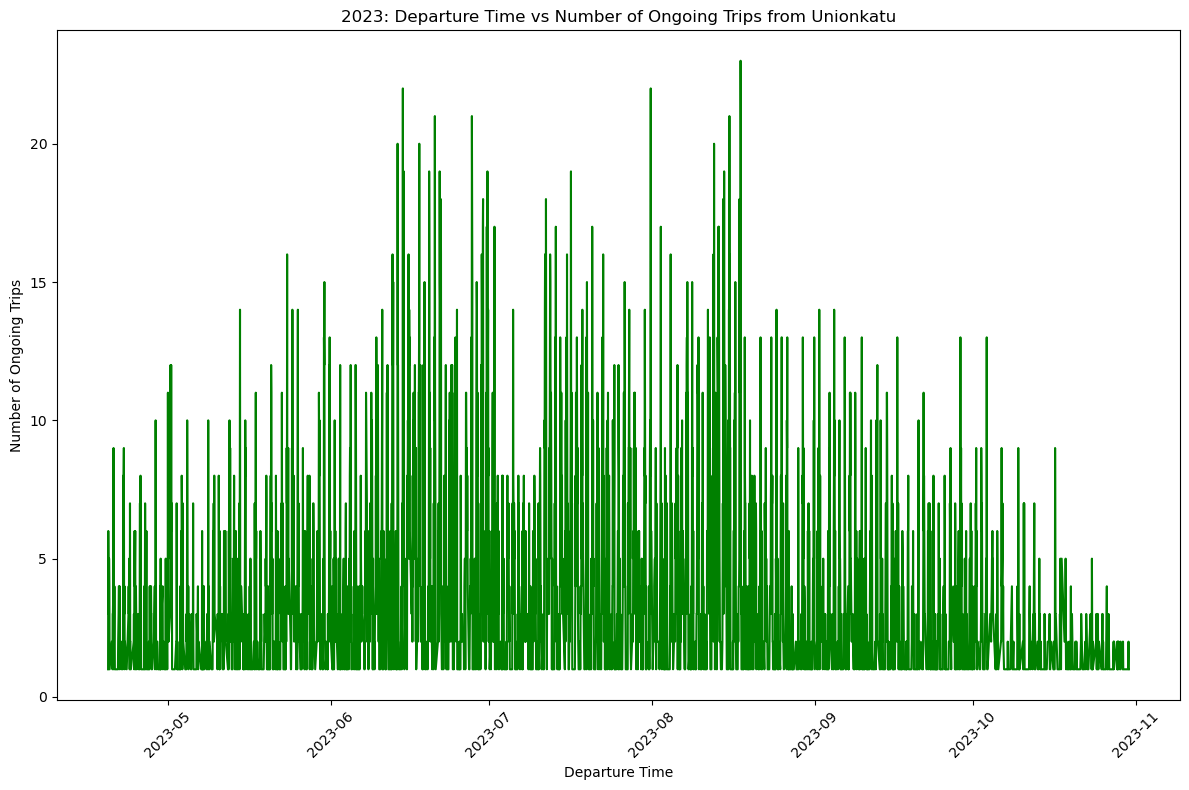

In [12]:
# from pathvalidate import sanitize_filename

# temp_df = pd.read_csv('datasets/2016-05.csv')

# temp_df['Departure'] = pd.to_datetime(temp_df['Departure'], format='mixed')
# temp_df['Return'] = pd.to_datetime(temp_df['Return'], format='mixed')

# stations = list(set(temp_df['Departure station name'].to_list()))

# for year in range(2016, 2024):
#   for station in stations:
#     filtered_df = bike_df[(bike_df['Departure station name'] == station) & (bike_df['Departure'].dt.year == year)]
#     agg_station = filtered_df.groupby([
#         'Departure station id',
#         'Departure station name',
#         pd.Grouper(key='Departure', freq='H'),
#     ]).size().reset_index(name='Trip count') # Trip count is the number of ongoing trips leaving from f'{Departure station name}'
#     agg_station.to_csv(f'datasets/aggregated_{year}_{sanitize_filename(station)}.csv', index=False)

test_df = pd.read_csv('datasets/aggregated_2023_Unioninkatu.csv')
test_df['Departure'] = pd.to_datetime(test_df['Departure'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Departure'], test_df['Trip count'], marker=None, linestyle='-', color='green')

plt.xlabel('Departure Time')
plt.ylabel('Number of Ongoing Trips')
plt.title('Sample Plot: Departure Time vs Number of Ongoing Trips from Unionkatu in 2023')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


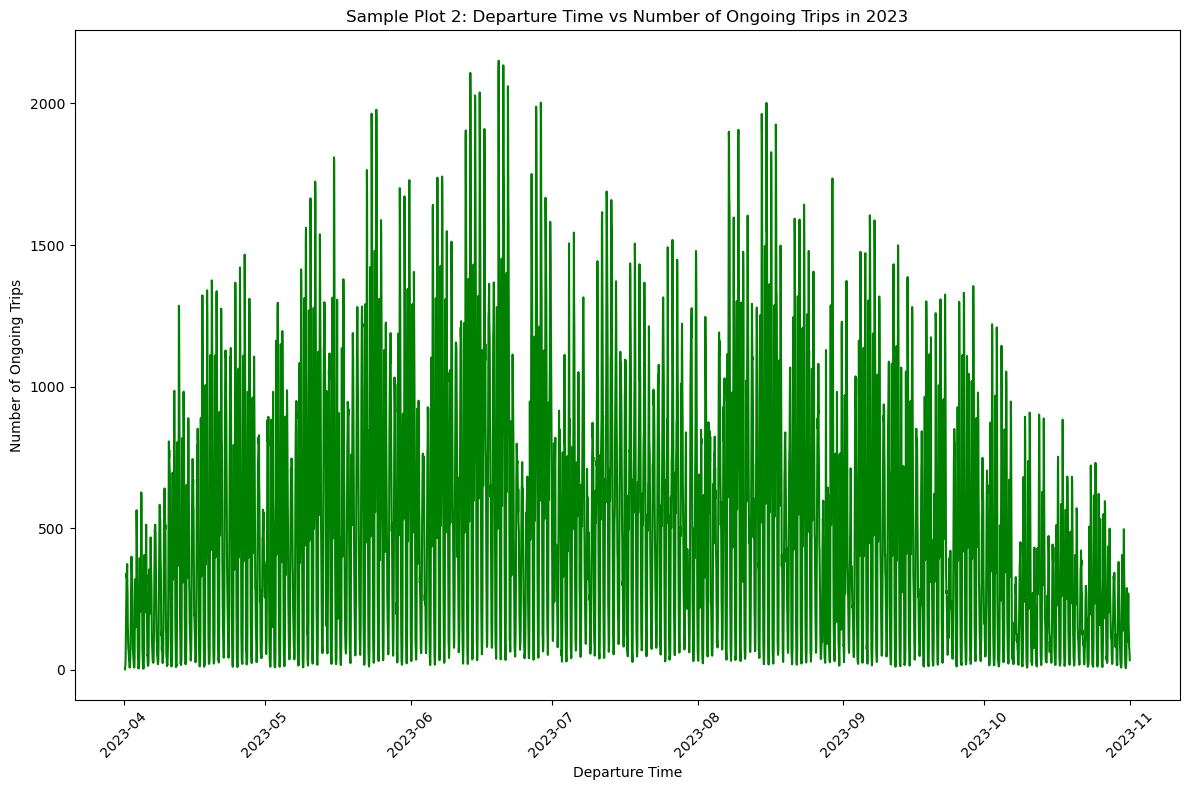

In [14]:
# aggregated = pd.DataFrame(columns=['Trip count'])

# for year in range(2016, 2024):
#   bike_df_year = bike_df[bike_df['Departure'].dt.year == year]
#   aggregated_year = bike_df_year.groupby([
#       pd.Grouper(key='Departure', freq='H'),
#   ]).size().reset_index(name='Trip count')
#   aggregated_year.to_csv(f'datasets/aggregated_over_all_stations_{year}.csv', index=False)

test_df = pd.read_csv('datasets/aggregated_over_all_stations_2023.csv')
test_df['Departure'] = pd.to_datetime(test_df['Departure'])

plt.figure(figsize=(12, 8))
plt.plot(test_df['Departure'], test_df['Trip count'], marker=None, linestyle='-', color='green')

plt.xlabel('Departure Time')
plt.ylabel('Number of Ongoing Trips')
plt.title('Sample Plot 2: Departure Time vs Number of Ongoing Trips in 2023')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

